In [ ]:
#|default_exp models.XCM

# XCM

> An Explainable Convolutional Neural Network for Multivariate Time Series Classification

This is an unofficial PyTorch implementation of XCM created by Ignacio Oguiza (oguiza@timeseriesAI.co)

In [ ]:
#|export
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *
from tsai.models.explainability import *

In [ ]:
#|export
# This is an unofficial PyTorch implementation of XVM created by Ignacio Oguiza - timeseriesAU@gmail.com based on:

# Fauvel, K., Lin, T., Masson, V., Fromont, É., & Termier, A. (2020). XCM: An Explainable Convolutional Neural Network 
# https://hal.inria.fr/hal-03469487/document
# Official tensorflow implementation available at: https://github.com/XAIseries/XCM
# No official XCM PyTorch implementation available as of Dec 11, 2021

class XCM(Module):
    def __init__(self, c_in:int, c_out:int, seq_len:Optional[int]=None, nf:int=128, window_perc:float=1., flatten:bool=False, custom_head:callable=None, 
                 concat_pool:bool=False, fc_dropout:float=0., bn:bool=False, y_range:tuple=None, **kwargs):
        
        window_size = int(round(seq_len * window_perc, 0))
        self.conv2dblock = nn.Sequential(*[Unsqueeze(1), Conv2d(1, nf, kernel_size=(1, window_size), padding='same'), BatchNorm(nf), nn.ReLU()])
        self.conv2d1x1block = nn.Sequential(*[nn.Conv2d(nf, 1, kernel_size=1), nn.ReLU(), Squeeze(1)])
        self.conv1dblock = nn.Sequential(*[Conv1d(c_in, nf, kernel_size=window_size, padding='same'), BatchNorm(nf, ndim=1), nn.ReLU()])
        self.conv1d1x1block = nn.Sequential(*[nn.Conv1d(nf, 1, kernel_size=1), nn.ReLU()])
        self.concat = Concat()
        self.conv1d = nn.Sequential(*[Conv1d(c_in + 1, nf, kernel_size=window_size, padding='same'), BatchNorm(nf, ndim=1), nn.ReLU()])
            
        self.head_nf = nf
        self.c_out = c_out
        self.seq_len = seq_len
        if custom_head: self.head = custom_head(self.head_nf, c_out, seq_len, **kwargs)
        else: self.head = self.create_head(self.head_nf, c_out, seq_len, flatten=flatten, concat_pool=concat_pool, 
                                           fc_dropout=fc_dropout, bn=bn, y_range=y_range)

            
    def forward(self, x):
        x1 = self.conv2dblock(x)
        x1 = self.conv2d1x1block(x1)
        x2 = self.conv1dblock(x)
        x2 = self.conv1d1x1block(x2)
        out = self.concat((x2, x1))
        out = self.conv1d(out)
        out = self.head(out)
        return out
    

    def create_head(self, nf, c_out, seq_len=None, flatten=False, concat_pool=False, fc_dropout=0., bn=False, y_range=None):
        if flatten: 
            nf *= seq_len
            layers = [Reshape()]
        else: 
            if concat_pool: nf *= 2
            layers = [GACP1d(1) if concat_pool else GAP1d(1)]
        layers += [LinBnDrop(nf, c_out, bn=bn, p=fc_dropout)]
        if y_range: layers += [SigmoidRange(*y_range)]
        return nn.Sequential(*layers)
    
    
    def show_gradcam(self, x, y=None, detach=True, cpu=True, apply_relu=True, cmap='inferno', figsize=None, **kwargs):
        
        if cpu:
            x = x.cpu()
            if y is not None: y = y.cpu()
        att_maps = get_attribution_map(self, [self.conv2dblock, self.conv1dblock], x, y=y, detach=detach, cpu=cpu, apply_relu=apply_relu)
        att_maps[0] = (att_maps[0] - att_maps[0].min()) / (att_maps[0].max() - att_maps[0].min())
        att_maps[1] = (att_maps[1] - att_maps[1].min()) / (att_maps[1].max() - att_maps[1].min())

        figsize = ifnone(figsize, (10, 10))
        fig = plt.figure(figsize=figsize, **kwargs)
        ax = plt.axes()
        plt.title('Observed variables')
        if att_maps[0].ndim == 3:
            att_maps[0] = att_maps[0].mean(0)
        im = ax.imshow(att_maps[0], cmap=cmap)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        plt.show()

        fig = plt.figure(figsize=figsize, **kwargs)
        ax = plt.axes()
        plt.title('Time')
        if att_maps[1].ndim == 3:
            att_maps[1] = att_maps[1].mean(0)
        im = ax.imshow(att_maps[1], cmap=cmap)
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        plt.show()

In [ ]:
from tsai.data.basics import *
from tsai.learner import *

In [ ]:
dsid = 'NATOPS'
X, y, splits = get_UCR_data(dsid, split_data=False)
tfms = [None, TSCategorize()]
dls = get_ts_dls(X, y, splits=splits, tfms=tfms)
model =  XCM(dls.vars, dls.c, dls.len)
learn = ts_learner(dls, model, metrics=accuracy)
xb, yb = dls.one_batch()

bs, c_in, seq_len = xb.shape
c_out = len(np.unique(yb.cpu().numpy()))

model = XCM(c_in, c_out, seq_len, fc_dropout=.5)
test_eq(model.to(xb.device)(xb).shape, (bs, c_out))
model = XCM(c_in, c_out, seq_len, concat_pool=True)
test_eq(model.to(xb.device)(xb).shape, (bs, c_out))
model = XCM(c_in, c_out, seq_len)
test_eq(model.to(xb.device)(xb).shape, (bs, c_out))
model

XCM(
  (conv2dblock): Sequential(
    (0): Unsqueeze(dim=1)
    (1): Conv2dSame(
      (conv2d_same): Conv2d(1, 128, kernel_size=(1, 51), stride=(1, 1))
    )
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv2d1x1block): Sequential(
    (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Squeeze(dim=1)
  )
  (conv1dblock): Sequential(
    (0): Conv1d(24, 128, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1d1x1block): Sequential(
    (0): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
    (1): ReLU()
  )
  (concat): Concat(dim=1)
  (conv1d): Sequential(
    (0): Conv1d(25, 128, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (head): Sequential(
    (0): GAP1d(
      (g

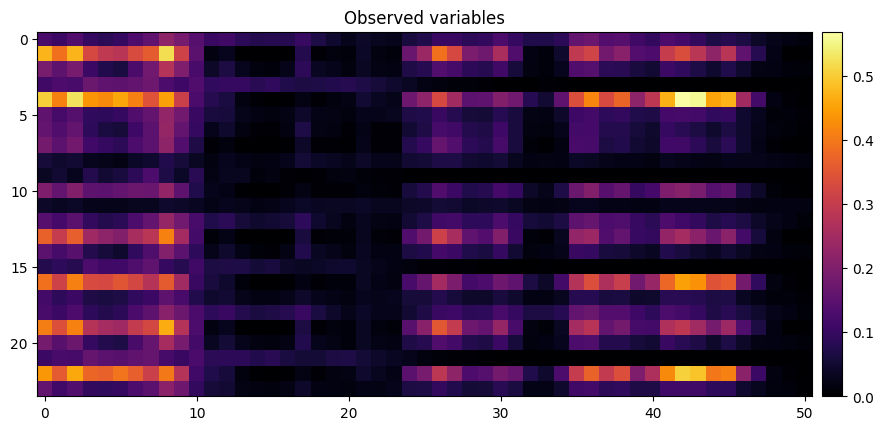

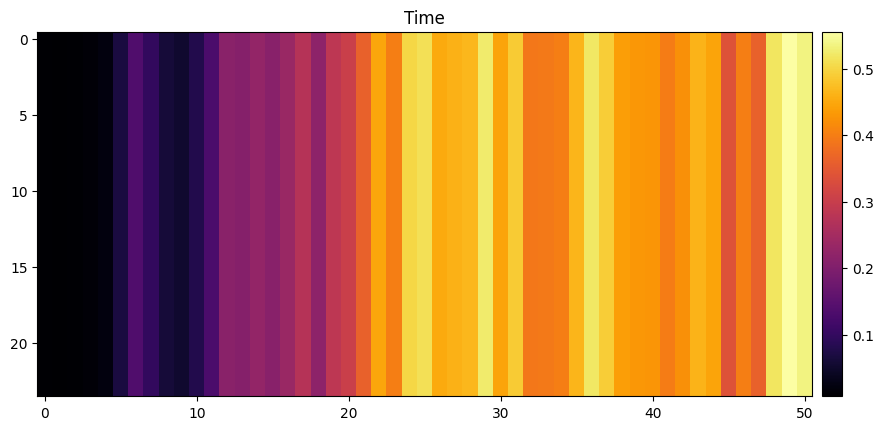

In [ ]:
model.show_gradcam(xb, yb)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


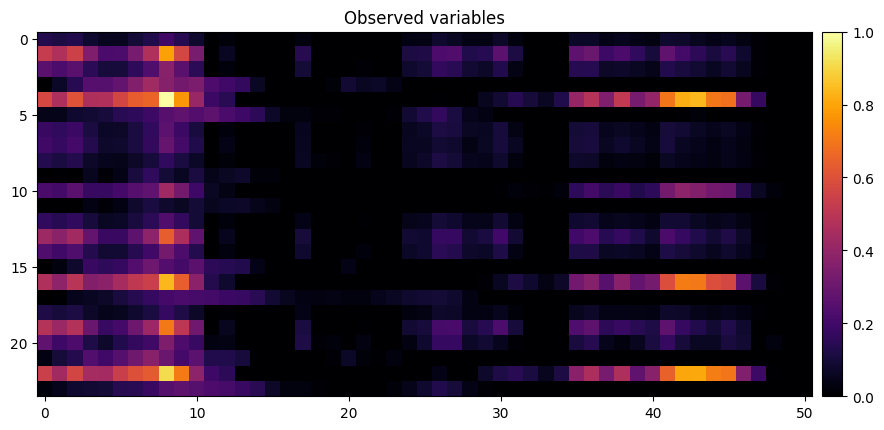

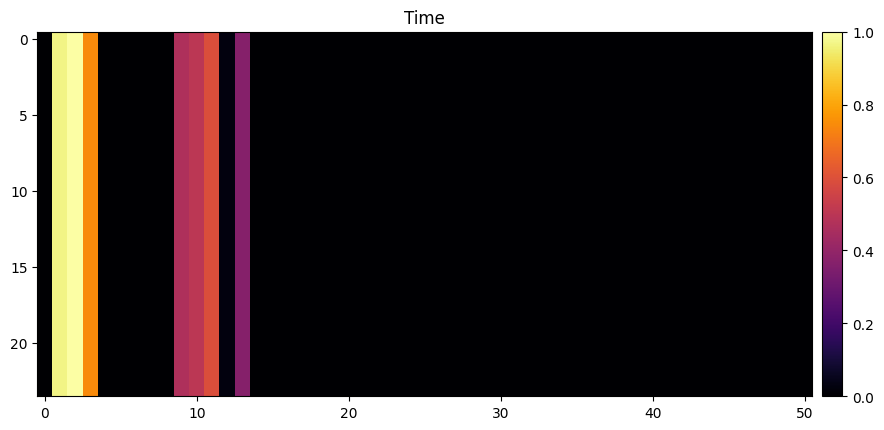

In [ ]:
model.show_gradcam(xb[0], yb[0])

In [ ]:
bs = 16
n_vars = 3
seq_len = 12
c_out = 10
xb = torch.rand(bs, n_vars, seq_len)
new_head = partial(conv_lin_nd_head, d=(5, 2))
net = XCM(n_vars, c_out, seq_len, custom_head=new_head)
print(net.to(xb.device)(xb).shape)
net.head

torch.Size([16, 5, 2, 10])


create_conv_lin_nd_head(
  (0): Conv1d(128, 10, kernel_size=(1,), stride=(1,))
  (1): Linear(in_features=12, out_features=10, bias=True)
  (2): Transpose(-1, -2)
  (3): Reshape(bs, 5, 2, 10)
)

In [ ]:
bs = 16
n_vars = 3
seq_len = 12
c_out = 2
xb = torch.rand(bs, n_vars, seq_len)
net = XCM(n_vars, c_out, seq_len)
change_model_head(net, create_pool_plus_head, concat_pool=False)
print(net.to(xb.device)(xb).shape)
net.head

torch.Size([16, 2])


Sequential(
  (0): AdaptiveAvgPool1d(output_size=1)
  (1): Reshape(bs)
  (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=128, out_features=512, bias=False)
  (4): ReLU(inplace=True)
  (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=512, out_features=2, bias=False)
)

In [ ]:
#|eval: false
#|hide
from tsai.export import get_nb_name; nb_name = get_nb_name(locals())
from tsai.imports import create_scripts; create_scripts(nb_name)

<IPython.core.display.Javascript object>

/Users/nacho/notebooks/tsai/nbs/061_models.XCM.ipynb saved at 2023-03-16 11:45:59
Correct notebook to script conversion! 😃
Thursday 16/03/23 11:46:02 CET
